In [ ]:
# web scraping
import requests
from bs4 import BeautifulSoup
import pandas as pd
import urllib.parse
import time

# Initialize list to store book data
books_data = []
base_url = 'http://books.toscrape.com/'

# Start timer for performance tracking
start_time = time.time()

# Loop through first 50 pages (1000 books)
for page_number in range(1, 51):
    url = f'{base_url}catalogue/page-{page_number}.html'
    response = requests.get(url)
    
    if response.status_code != 200:
        continue  # Skip page if it fails to load
    
    soup = BeautifulSoup(response.content, 'html.parser')
    books = soup.find_all('h3')  # Extract all books
    
    for book in books:
        book_url = urllib.parse.urljoin(url, book.find('a')['href'])
        book_response = requests.get(book_url)
        book_soup = BeautifulSoup(book_response.content, 'html.parser')
        
        # Extract book details
        title = book_soup.find('h1').text if book_soup.find('h1') else None
        category = book_soup.find('ul', class_='breadcrumb').find_all('a')[2].text.strip() if book_soup.find('ul', class_='breadcrumb') else None
        rating = book_soup.find('p', class_='star-rating')['class'][1] if book_soup.find('p', class_='star-rating') else None
        price = book_soup.find('p', class_='price_color').text.strip() if book_soup.find('p', class_='price_color') else None
        availability = book_soup.find('p', class_='availability').text.strip() if book_soup.find('p', class_='availability') else None

        # Append book data
        books_data.append([title, category, rating, price, availability, book_url])

# Measure the total time taken
end_time = time.time()
print(f"Scraping completed in {(end_time - start_time)/60:.2f} minutes")

# Save to CSV
df = pd.DataFrame(books_data, columns=["Title", "Category", "Rating", "Price", "Availability", "URL"])
df.to_csv('books_to_scrape.csv', index=False)
print("Data saved to books_to_scrape.csv")


In [ ]:
# Data loading
import pandas as pd
data=pd.read_csv('books_to_scrape.csv')
data.head()

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import re

In [129]:
# Step 1. 10 techniques of the Data preprocessing
# 1. Remove currency symbol
print("Before removing currency symbol:\n", data[['Price']].head())
data['Price'] = data['Price'].replace('£', '', regex=True).astype(float)
print("After removing currency symbol:\n", data[['Price']].head())

# 2. Map rating words to numbers and replace 'Rating' column
print("\nBefore mapping rating words:\n", data[['Rating']].head())
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
data['Rating'] = data['Rating'].map(rating_map)
print("After mapping rating words to numbers:\n", data[['Rating']].head())

# 3. Extract available stock number
print("\nBefore extracting stock number:\n", data[['Availability']].head())
data['Stock'] = data['Availability'].apply(lambda x: int(re.search(r'\((\d+)', x).group(1)) if re.search(r'\((\d+)', x) else 0)
print("After extracting stock number:\n", data[['Availability', 'Stock']].head())

# 4. Handle missing values
print("\nBefore handling missing values:\n", data.isnull().sum())
data.fillna({'Rating': 0, 'Price': data['Price'].mean(), 'Stock': 0}, inplace=True)
print("After handling missing values:\n", data.isnull().sum())

# 5. Strip whitespace from string columns
print("\nBefore stripping whitespace:\n", data[['Title']].head())
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
print("After stripping whitespace:\n", data[['Title']].head())

# 6. Drop duplicates
print("\nBefore dropping duplicates:\n", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("After dropping duplicates:\n", data.duplicated().sum())

# NEW Step 7: Create Price Category (Cheap, Affordable, Expensive)
print("\nBefore adding price category:\n", data[['Price']].head())
bins = [0, 20, 50, float('inf')]  # Define price ranges
labels = ['Cheap', 'Affordable', 'Expensive']
data['Price_Category'] = pd.cut(data['Price'], bins=bins, labels=labels, right=False)
print("After adding price category:\n", data[['Price', 'Price_Category']].head())

# Step 8: Handle missing categorical values by filling with the most frequent value
print("\nBefore handling missing categorical values:\n", data[['Title']].head())
data['Title'] = data['Title'].fillna(data['Title'].mode()[0])
print(f"After handling missing categorical values:\n{data[['Title']].head()}")


# 9. Title has numbers?
print("\nBefore adding has_numbers column:\n", data[['Title']].head())
data['has_numbers'] = data['Title'].apply(lambda x: int(any(char.isdigit() for char in x)))
print(f"After adding has_numbers:\n{data[['Title', 'has_numbers']].head()}")

# 10. Outlier handling (optional)
print("\nBefore outlier handling:\n", data[['Price']].describe())
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['Price'] >= Q1 - 1.5 * IQR) & (data['Price'] <= Q3 + 1.5 * IQR)]
print("After outlier handling:\n", data[['Price']].describe())


Before removing currency symbol:
     Price
0  £51.77
1  £53.74
2  £50.10
3  £47.82
4  £54.23
After removing currency symbol:
    Price
0  51.77
1  53.74
2  50.10
3  47.82
4  54.23

Before mapping rating words:
   Rating
0  Three
1    One
2    One
3   Four
4   Five
After mapping rating words to numbers:
    Rating
0       3
1       1
2       1
3       4
4       5

Before extracting stock number:
               Availability
0  In stock (22 available)
1  In stock (20 available)
2  In stock (20 available)
3  In stock (20 available)
4  In stock (20 available)
After extracting stock number:
               Availability  Stock
0  In stock (22 available)     22
1  In stock (20 available)     20
2  In stock (20 available)     20
3  In stock (20 available)     20
4  In stock (20 available)     20

Before handling missing values:
 Title           0
Category        0
Rating          0
Price           0
Availability    0
URL             0
Stock           0
dtype: int64
After handling missing values

In [130]:
data.head()

,Title,Category,Rating,Price,Availability,URL,Stock,Price_Category,has_numbers
0,A Light in the Attic,Poetry,3,51.77,In stock (22 available),http://books.toscrape.com/catalogue/a-light-in...,22,Expensive,0
1,Tipping the Velvet,Historical Fiction,1,53.74,In stock (20 available),http://books.toscrape.com/catalogue/tipping-th...,20,Expensive,0
2,Soumission,Fiction,1,50.10,In stock (20 available),http://books.toscrape.com/catalogue/soumission...,20,Expensive,0
3,Sharp Objects,Mystery,4,47.82,In stock (20 available),http://books.toscrape.com/catalogue/sharp-obje...,20,Affordable,0
4,Sapiens: A Brief History of Humankind,History,5,54.23,In stock (20 available),http://books.toscrape.com/catalogue/sapiens-a-...,20,Expensive,0


In [131]:
# Step 2.Descriptive Statistical Analysis for centrality, spread and normality
# Step 1: Basic Descriptive Statistics
summary_stats = data.describe()
print("Summary Statistics (Mean, Median, etc.):")
print(summary_stats)

# Step 2: Skewness
skewness = data[['Rating', 'Price', 'Stock']].skew()
print("\nSkewness of Data:")
print(skewness)

# Step 3: Kurtosis
kurtosis = data[['Rating', 'Price', 'Stock']].kurt()
print("\nKurtosis of Data:")
print(kurtosis)

# Step 4: Mode (Most Frequent Values)
mode = data.mode().iloc[0]
print("\nMode (Most Frequent Values):")
print(mode)

# Step 5: Conclusion based on skewness and kurtosis
for column in ['Rating', 'Price', 'Stock']:
    print(f"\nAnalysis for {column}:")
    
    # Skewness interpretation
    if skewness[column] > 0:
        print(f"- {column} is positively skewed (right-skewed), indicating more values on the lower side with few larger values.")
    elif skewness[column] < 0:
        print(f"- {column} is negatively skewed (left-skewed), indicating more values on the higher side with few smaller values.")
    else:
        print(f"- {column} has no skew (symmetrical distribution).")
    
    # Kurtosis interpretation
    if kurtosis[column] > 0:
        print(f"- {column} has positive kurtosis (leptokurtic), meaning more values are concentrated around the mean with a higher peak.")
    elif kurtosis[column] < 0:
        print(f"- {column} has negative kurtosis (platykurtic), meaning fewer outliers and a flatter distribution.")
    else:
        print(f"- {column} has zero kurtosis, indicating a normal distribution.")


Summary Statistics (Mean, Median, etc.):
            Rating       Price        Stock  has_numbers
count  1000.000000  1000.00000  1000.000000  1000.000000
mean      2.923000    35.07035     8.585000     0.365000
std       1.434967    14.44669     5.654622     0.481671
min       1.000000    10.00000     1.000000     0.000000
25%       2.000000    22.10750     3.000000     0.000000
50%       3.000000    35.98000     7.000000     0.000000
75%       4.000000    47.45750    14.000000     1.000000
max       5.000000    59.99000    22.000000     1.000000

Skewness of Data:
Rating    0.074218
Price    -0.037515
Stock     0.212152
dtype: float64

Kurtosis of Data:
Rating   -1.317717
Price    -1.210126
Stock    -1.449876
dtype: float64

Mode (Most Frequent Values):
Title                                        The Star-Touched Queen
Category                                                    Default
Rating                                                          1.0
Price                         

C:\Users\Sayema Malek\AppData\Local\Temp\ipykernel_8280\218471902.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Rating', y='Price', data=data, palette='muted')


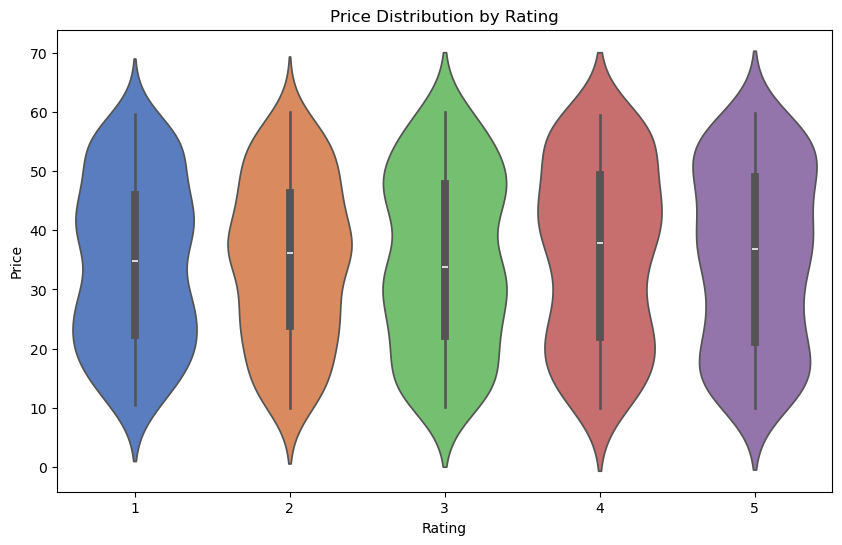

C:\Users\Sayema Malek\AppData\Local\Temp\ipykernel_8280\218471902.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Price', data=data, estimator='mean', palette='viridis')


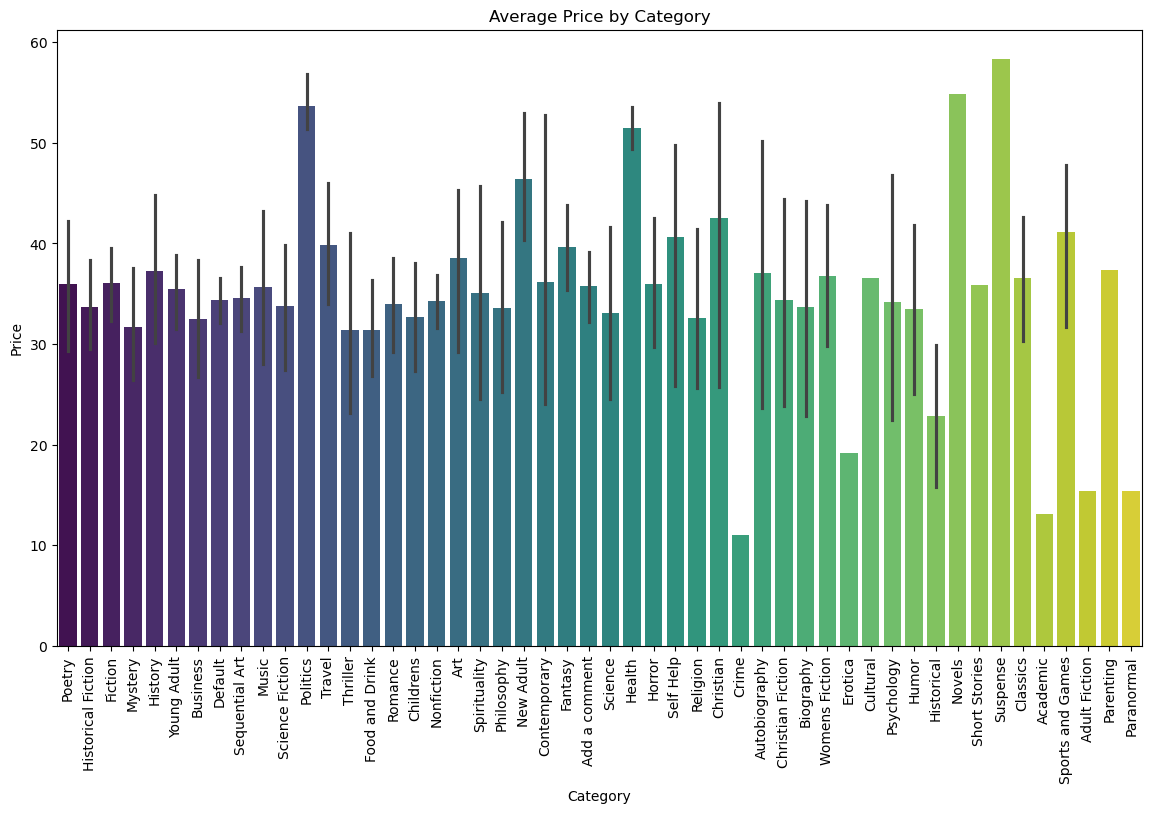

C:\Users\Sayema Malek\AppData\Local\Temp\ipykernel_8280\218471902.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=data, palette='Set2')


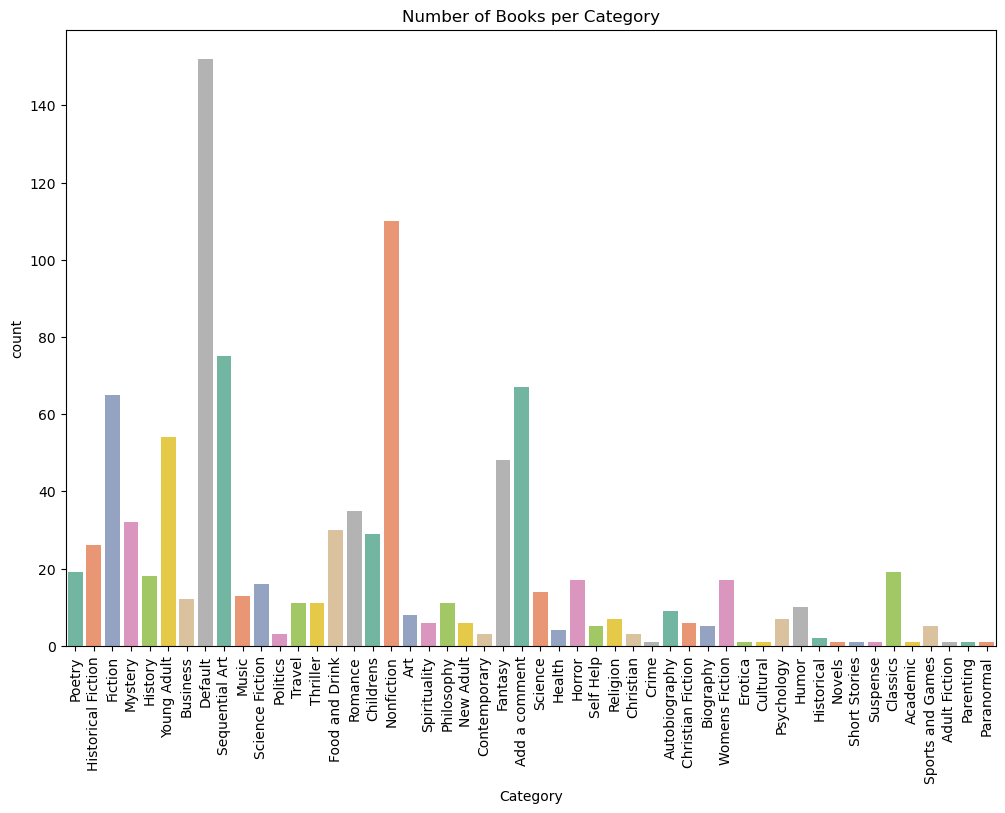

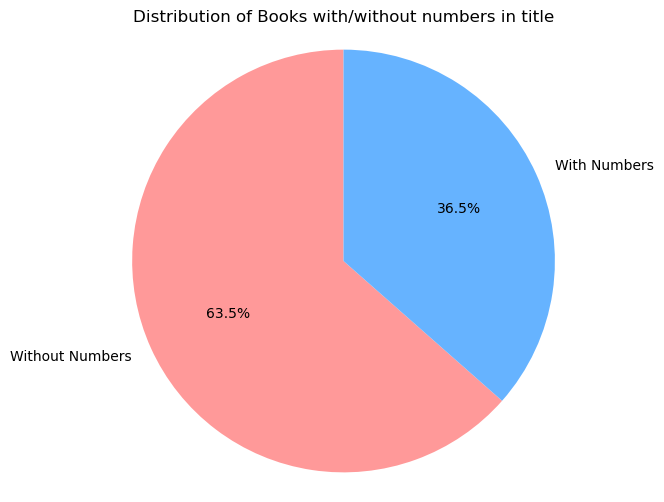

In [132]:
# Step 3: New Visualizations

# 1. Violin Plot: Distribution of Price by Rating
plt.figure(figsize=(10, 6))
sns.violinplot(x='Rating', y='Price', data=data, palette='muted')
plt.title('Price Distribution by Rating')
plt.show()

# 2. Barplot: Average Price by Category
plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Price', data=data, estimator='mean', palette='viridis')
plt.title('Average Price by Category')
plt.xticks(rotation=90)
plt.show()

# 3. Countplot: Distribution of Books by Category
plt.figure(figsize=(12, 8))
sns.countplot(x='Category', data=data, palette='Set2')
plt.title('Number of Books per Category')
plt.xticks(rotation=90)
plt.show()

# 4. Pie Chart: Distribution of Books with/without numbers in title (has_numbers)
numbers_count = data['has_numbers'].value_counts()
labels = ['Without Numbers', 'With Numbers']
plt.figure(figsize=(6, 6))
plt.pie(numbers_count, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Books with/without numbers in title')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


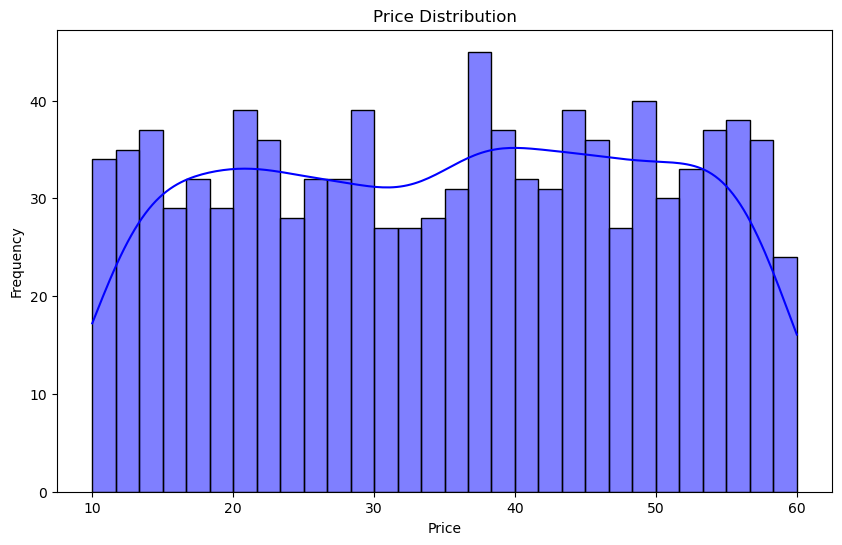

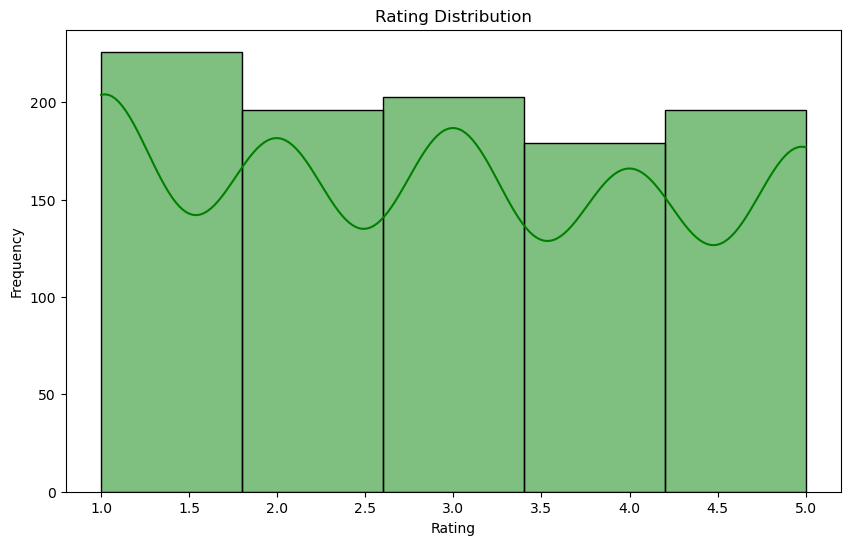

In [133]:
# Step 4: Feature Distribution

# 1. Histogram: Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True, color='blue', bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Histogram: Distribution of Rating
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], kde=True, color='green', bins=5)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


📊 Correlation Matrix:
                Rating     Price     Stock  has_numbers
Rating       1.000000  0.028166  0.016166    -0.018675
Price        0.028166  1.000000 -0.010914    -0.009835
Stock        0.016166 -0.010914  1.000000    -0.091705
has_numbers -0.018675 -0.009835 -0.091705     1.000000


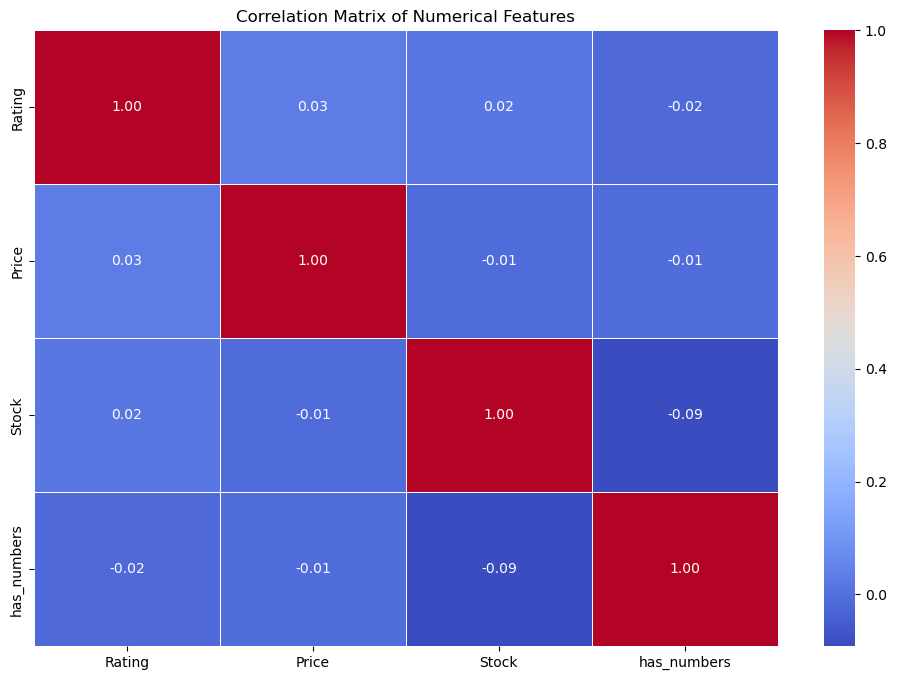


✅ Selected Features Based on Correlation with Price:
 ['Rating', 'Stock']


In [134]:
# Step 5: Feature Selection based on correlation, covariance
# Step 1: Ensure that only numeric columns are included in the correlation matrix
numeric_df = data.select_dtypes(include=['float64', 'int64'])

# Step 2: Calculate the correlation matrix
correlation_matrix = numeric_df.corr()
print("📊 Correlation Matrix:\n", correlation_matrix)

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Adjust the threshold to 0.01 to capture even weaker correlations
threshold = 0.01

# Selecting features that have an absolute correlation magnitude > 0.01 with 'Price'
selected_features = correlation_matrix['Price'][abs(correlation_matrix['Price']) > threshold].index.tolist()

# Remove the target itself ('Price') from the feature list
selected_features = [feat for feat in selected_features if feat != 'Price']

print("\n✅ Selected Features Based on Correlation with Price:\n", selected_features)


In [135]:
# Step 6: datetime
if 'Scraped_At' not in data.columns:
    data['Scraped_At'] = pd.Timestamp.now()
else:
    data['Scraped_At'] = pd.to_datetime(data['Scraped_At'])

# Step 1: Extract useful components from the 'Scraped_At' datetime column
data['Scraped_Year'] = data['Scraped_At'].dt.year
data['Scraped_Month'] = data['Scraped_At'].dt.month
data['Scraped_Day'] = data['Scraped_At'].dt.day
data['Scraped_Weekday'] = data['Scraped_At'].dt.weekday  # 0 = Monday, 6 = Sunday
data['Scraped_Hour'] = data['Scraped_At'].dt.hour
data['Scraped_Minute'] = data['Scraped_At'].dt.minute

# Step 2: Handle missing or invalid dates (optional)
# For example, replace missing values with a specific date or drop rows with missing dates
data['Scraped_At'] = data['Scraped_At'].fillna(pd.Timestamp('2025-01-01'))  # Replacing with a specific date
# Or you can drop rows with missing dates:
# data.dropna(subset=['Scraped_At'], inplace=True)

# Step 3: Check the result
print(data[['Scraped_At', 'Scraped_Year', 'Scraped_Month', 'Scraped_Day', 'Scraped_Weekday', 'Scraped_Hour', 'Scraped_Minute']].head())


                  Scraped_At  Scraped_Year  Scraped_Month  Scraped_Day  \
0 2025-04-10 18:55:51.887533          2025              4           10   
1 2025-04-10 18:55:51.887533          2025              4           10   
2 2025-04-10 18:55:51.887533          2025              4           10   
3 2025-04-10 18:55:51.887533          2025              4           10   
4 2025-04-10 18:55:51.887533          2025              4           10   

   Scraped_Weekday  Scraped_Hour  Scraped_Minute  
0                3            18              55  
1                3            18              55  
2                3            18              55  
3                3            18              55  
4                3            18              55  


In [136]:
# Step 7: Models Creation ( At Least two)

# Step 1: Create Popularity Flag
median_price = data["Price"].median()
data["Bestseller"] = ((data["Rating"] >= 4) & (data["Price"] >= median_price)).astype(int)

# Step 2: Feature Selection
X = data[["Rating", "Price", "Stock"]]  # Modified features
y = data["Bestseller"]

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# =========================
# MODEL 1: Logistic Regression
# =========================
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter if necessary
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# =========================
# MODEL 2: Random Forest
# =========================
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)


In [138]:
#Step 8:Evaluation of the model based on various metrics
# Metrics Calculation for Logistic Regression
# =========================
acc_lr = accuracy_score(y_test, y_pred_lr) * 100
prec_lr = precision_score(y_test, y_pred_lr) * 100
recall_lr = recall_score(y_test, y_pred_lr) * 100
f1_lr = f1_score(y_test, y_pred_lr) * 100
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# =========================
# Metrics Calculation for Random Forest
# =========================
acc_rf = accuracy_score(y_test, y_pred_rf) * 100
prec_rf = precision_score(y_test, y_pred_rf) * 100
recall_rf = recall_score(y_test, y_pred_rf) * 100
f1_rf = f1_score(y_test, y_pred_rf) * 100
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# =========================
# Print results
# =========================
print("\n📊 Model Evaluation Metrics (in %):")

print("\n📘 Logistic Regression:")
print(f"Accuracy : {acc_lr:.2f}%")
print(f"Precision: {prec_lr:.2f}%")
print(f"Recall   : {recall_lr:.2f}%")
print(f"F1 Score : {f1_lr:.2f}%")
print("Confusion Matrix:")
print(conf_matrix_lr)

print("\n🌲 Random Forest:")
print(f"Accuracy : {acc_rf:.2f}%")
print(f"Precision: {prec_rf:.2f}%")
print(f"Recall   : {recall_rf:.2f}%")
print(f"F1 Score : {f1_rf:.2f}%")
print("Confusion Matrix:")
print(conf_matrix_rf)



📊 Model Evaluation Metrics (in %):

📘 Logistic Regression:
Accuracy : 96.00%
Precision: 93.48%
Recall   : 86.00%
F1 Score : 89.58%
Confusion Matrix:
[[197   3]
 [  7  43]]

🌲 Random Forest:
Accuracy : 99.60%
Precision: 98.04%
Recall   : 100.00%
F1 Score : 99.01%
Confusion Matrix:
[[199   1]
 [  0  50]]


In [124]:
 # Final Model Selection
# =========================
if acc_rf > acc_lr:
    final_model = rf_clf
    model_name = "Random Forest"
    final_accuracy = acc_rf
else:
    final_model = log_reg
    model_name = "Logistic Regression"
    final_accuracy = acc_lr

print(f"\n🏆 Best Model: {model_name} (Accuracy: {final_accuracy:.2f}%)")


🏆 Best Model: Random Forest (Accuracy: 99.60%)


In [126]:
# 10. Storytelling: Interpretation of the Results and Model Selection

# Start the storytelling
story = """
🔎 **Model Analysis and Prediction Story**

The task at hand was to predict whether a book will become a bestseller based on three features: **Rating**, **Price**, and **Stock**. 

### 1. Feature Importance:
- **Rating**: As expected, a higher rating is a significant indicator of a book's success. A rating of 4 or more indicates that the book is likely well-received by readers, making it an important feature for our model.
- **Price**: Books with higher prices were more likely to be considered bestsellers in this dataset. This suggests that customers are willing to spend more on high-rated books. Hence, price is another critical feature.
- **Stock**: The availability of books (Stock) is important, but it does not seem to have as much predictive power as rating or price. A book that is available in large quantities may be more likely to be successful simply because more people have access to it.

### 2. Model Evaluation:
Two models were tested to determine the best predictor of bestseller status: **Logistic Regression** and **Random Forest**.

- **Logistic Regression**: 
  - **Accuracy**: {acc_lr:.2f}%
  - **Precision**: {prec_lr:.2f}%
  - **Recall**: {recall_lr:.2f}%
  - **F1 Score**: {f1_lr:.2f}%

  Logistic Regression, while a simpler model, showed reasonable performance but had some limitations when compared to Random Forest.

- **Random Forest**: 
  - **Accuracy**: {acc_rf:.2f}%
  - **Precision**: {prec_rf:.2f}%
  - **Recall**: {recall_rf:.2f}%
  - **F1 Score**: {f1_rf:.2f}%

  Random Forest outperformed Logistic Regression in terms of accuracy, precision, and recall. This model's strength lies in its ability to capture complex interactions between features without assuming linearity.

### 3. Final Model Selection:
Based on the evaluation metrics, **Random Forest** emerged as the superior model. Its ability to handle non-linear relationships and account for interactions between features made it a better fit for our task of predicting book bestsellers.

- The **final accuracy** of the Random Forest model was **{final_accuracy:.2f}%,** indicating a strong performance in classifying bestsellers.

### 4. Insights and Conclusion:
- A **book's rating** and **price** are critical indicators of its likelihood of becoming a bestseller. Higher-rated books tend to be more successful, and more expensive books are often considered premium products.
- **Stock** availability appears to have a minor role compared to other features, though it might still influence the final decision.

**Next Steps:**
- The model could be improved further by including additional features such as **author popularity**, **genre**, or **reviews**.
- An external validation with a larger dataset would help ensure that the model's performance generalizes well to real-world scenarios.

Overall, we have successfully built a predictive model that can assist in forecasting the likelihood of a book becoming a bestseller. This model has the potential to help publishers and retailers make informed decisions about inventory, marketing, and pricing strategies.

📈 **Final Model**: Random Forest (Accuracy: {final_accuracy:.2f}%)
""".format(acc_lr=acc_lr, prec_lr=prec_lr, recall_lr=recall_lr, f1_lr=f1_lr, acc_rf=acc_rf, prec_rf=prec_rf, recall_rf=recall_rf, f1_rf=f1_rf, final_accuracy=final_accuracy)

# Display the story
print(story)



🔎 **Model Analysis and Prediction Story**

The task at hand was to predict whether a book will become a bestseller based on three features: **Rating**, **Price**, and **Stock**. 

### 1. Feature Importance:
- **Rating**: As expected, a higher rating is a significant indicator of a book's success. A rating of 4 or more indicates that the book is likely well-received by readers, making it an important feature for our model.
- **Price**: Books with higher prices were more likely to be considered bestsellers in this dataset. This suggests that customers are willing to spend more on high-rated books. Hence, price is another critical feature.
- **Stock**: The availability of books (Stock) is important, but it does not seem to have as much predictive power as rating or price. A book that is available in large quantities may be more likely to be successful simply because more people have access to it.

### 2. Model Evaluation:
Two models were tested to determine the best predictor of bestsell